In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json 
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [ ]:
pip install tensorflow==1.14

In [ ]:
path = "/content/drive/MyDrive/Colab-Notebooks/Stock-Analysis/Data/"
data = pd.read_csv(path+"NFLX.csv" , header=0 )

In [ ]:
data = data.sort_values('Date')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-27,7.142857,7.311429,6.992857,7.281429,7.281429,23347100
1,2010-01-28,8.812857,9.121429,8.675714,9.005714,9.005714,77352800
2,2010-01-29,8.962857,9.224286,8.792857,8.892857,8.892857,24604300
3,2010-02-01,8.830000,8.981429,8.532857,8.718571,8.718571,18914000
4,2010-02-02,8.707143,8.878571,8.695714,8.835714,8.835714,10242400


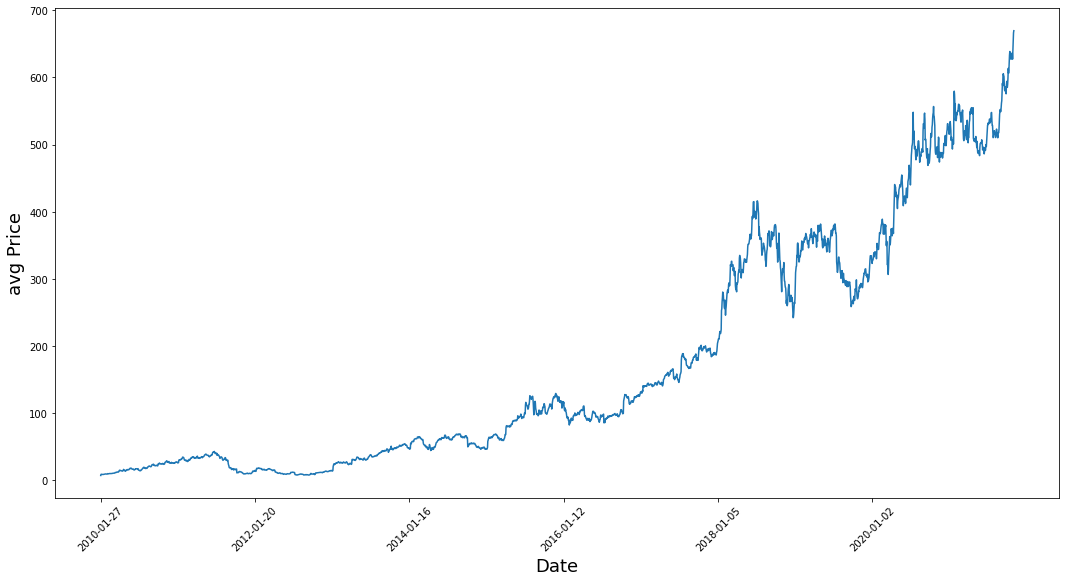

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(range(data.shape[0]),(data['Low']+data['High'])/2.0)
plt.xticks(range(0,data.shape[0],500),data['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('avg Price',fontsize=18)
plt.show()

In [ ]:
high_prices = data.loc[:,'High'].values
low_prices = data.loc[:,'Low'].values
avg_prices = (high_prices+low_prices)/2.0

In [ ]:
scale = MinMaxScaler()
train_avg = avg_prices[:2360]
test_avg = avg_prices[2360:]
train_avg = train_avg.reshape(-1,1)
test_avg = test_avg.reshape(-1,1)
window = 500
for x in range(0,2000,window):
  scale.fit(train_avg[x:x+window,:])
  train_avg[x:x+window,:] = scale.transform(train_avg[x:x+window,:])
scale.fit(train_avg[x+window:,:])
train_avg[x+window:,:] = scale.transform(train_avg[x+window:,:])

In [ ]:
train_avg = train_avg.reshape(-1)
test_avg = scale.transform(test_avg).reshape(-1)

In [ ]:
window = 100 # chose standard window size of 100
N = train_avg.size
mse_err = []
_avg_pred = [] #create a list for average x, predictions and mse errors
_avg_x = []

for idx1 in range(window,N): #make a for loop where if the value is greater than size then use timedelta function for that 1 day
    
    if idx1 >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = data.loc[idx1,'Date']  #if not just find that value in the dataframe for the data and put it in date
        
    _avg_pred.append(np.mean(train_avg[idx1-window:idx1])) #Keep apending values into into the lists
    mse_err.append((_avg_pred[-1]-train_avg[idx1])**2)   #calculate mse errors
    _avg_x.append(date) #this is the x train for averages we will use to train 

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_err)))

MSE error for standard averaging: 0.02291


In [ ]:
avg_data = np.concatenate([train_avg,test_avg],axis=0)

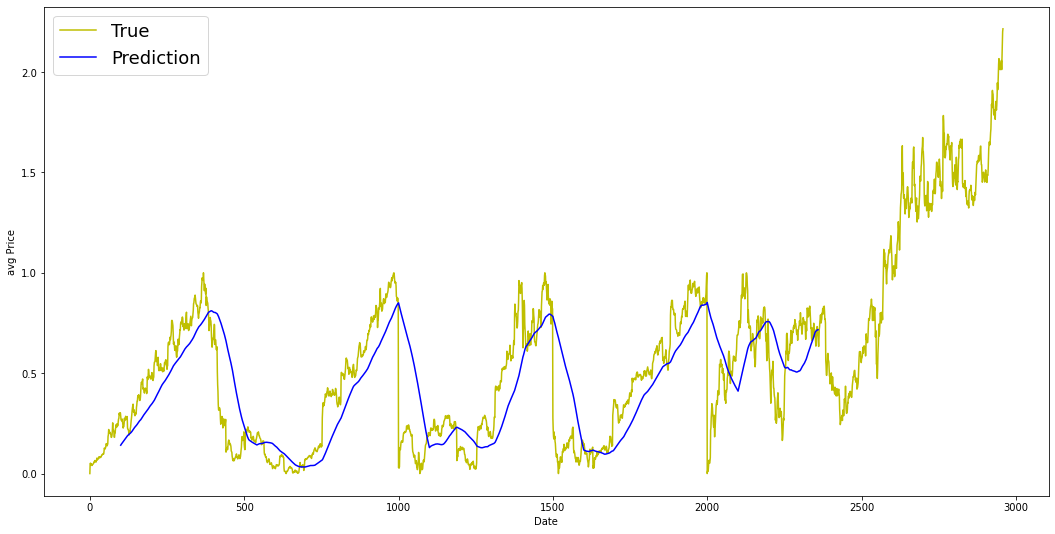

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(range(data.shape[0]),avg_data,color='y',label='True')
plt.plot(range(window,N),_avg_pred,color='b',label='Prediction')
plt.xlabel('Date')
plt.ylabel('avg Price')
plt.legend(fontsize=18)
plt.show()

In [ ]:
window = 100
N = train_avg.size
mse_err = []
_avg_predictions_run = []
_avg_x_run = []

running_mean = 0.0 
_avg_predictions_run.append(running_mean) 

decay = 0.5 
for idx1 in range(1,N): 
     
    running_mean = running_mean*decay + (1.0-decay)*train_avg[idx1-1]
    _avg_predictions_run.append(running_mean)
    mse_err.append((_avg_predictions_run[-1]-train_avg[idx1])**2)
    _avg_x_run.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_err)))

MSE error for EMA averaging: 0.00100


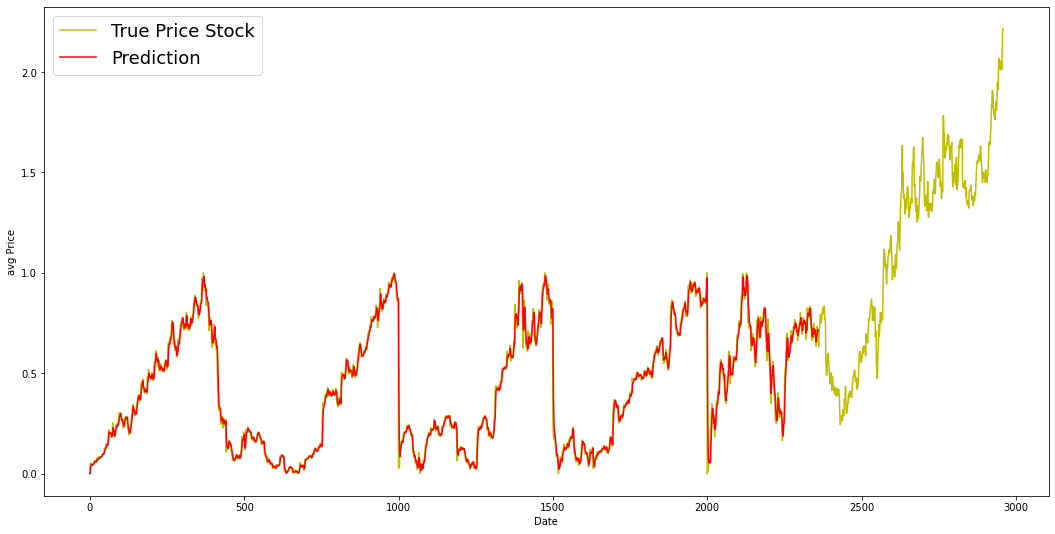

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(range(data.shape[0]),avg_data,color='y',label='True Price Stock')
plt.plot(range(0,N),_avg_predictions_run,color='r', label='Prediction')
plt.xlabel('Date')
plt.ylabel('avg Price')
plt.legend(fontsize=18)
plt.show()

In [ ]:
class Generator(object):   
    
    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next(self): 
        
        batch_data = np.zeros((self._batch_size),dtype=np.float32) 
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)
        
        for b in range(self._batch_size):   #create batches 
            if self._cursor[b]+1>=self._prices_length:
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)
                
            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(1,5)]
            
            self._cursor[b] = (self._cursor[b]+1)%self._prices_length
            
        return batch_data,batch_labels
    
    def unroll(self):  
            
        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):
            
            data, labels = self.next()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels
    
    def reset_indices(self): 
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))
        


dg = Generator(train_avg,5,5)
u_data, u_labels = dg.unroll()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [0.         0.08007819 0.8327337  0.6320342  0.85048705]

	Output: [0.04482704 0.08360931 0.8088188  0.6453313  0.85154223]


Unrolled index 1
	Inputs:  [0.04877708 0.08360931 0.845472   0.6453313  0.8628652 ]

	Output: [0.05184934 0.08067668 0.8183113  0.64397806 0.8626623 ]


Unrolled index 2
	Inputs:  [0.05184934 0.08195347 0.8494527  0.64133036 0.85154223]

	Output: [0.04566491 0.09787335 0.8183113  0.64397806 0.81801945]


Unrolled index 3
	Inputs:  [0.04482704 0.09220763 0.8183113  0.64397806 0.8626623 ]

	Output: [0.04803894 0.08067668 0.8210365  0.71016955 0.81737006]


Unrolled index 4
	Inputs:  [0.04566491 0.09787335 0.8088188  0.60961735 0.83088475]

	Output: [0.04438814 0.08225273 0.8210365  0.6156187  0.81562495]


In [ ]:
D = 1 
no_unrolling = 50 
batch_size = 500  
nodes = [200,200,150] 
num_layers = len(nodes) 
dropout = 0.2 


In [ ]:
train_inputs, train_outputs = [],[]
for ui in range(no_unrolling):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))

In [ ]:
lstm_cells = [
    tf.contrib.rnn.LSTMCell(num_units=nodes[li],
                            state_is_tuple=True,
                            initializer= tf.contrib.layers.xavier_initializer()
                           )
 for li in range(num_layers)]

drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
    lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]
drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

w = tf.get_variable('w',shape=[nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.


In [ ]:
feat, labs = [],[]
initial_state = []
for li in range(num_layers):
  feat.append(tf.Variable(tf.zeros([batch_size, nodes[li]]), trainable=False))
  labs.append(tf.Variable(tf.zeros([batch_size, nodes[li]]), trainable=False))
  initial_state.append(tf.contrib.rnn.LSTMStateTuple(feat[li], labs[li]))
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)
all_lstm_outputs, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major = True, dtype=tf.float32)
all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*no_unrolling,nodes[-1]])
all_outputs = tf.nn.xw_plus_b(all_lstm_outputs,w,b)
split_outputs = tf.split(all_outputs,no_unrolling,axis=0)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
print('Loss for the input train while converting prices into movements')
loss = 0.0
with tf.control_dependencies([tf.assign(feat[li], state[li][0]) for li in range(num_layers)]+
                             [tf.assign(labs[li], state[li][1]) for li in range(num_layers)]):
  for ui in range(no_unrolling):
    loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.assign(global_step,global_step + 1)
tf_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(
    tf.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

# Optimizer.
print('TF Optimization operations')
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ =  tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(
    zip(gradients, v))

Loss for the input train while converting prices into movements
Learning rate decay operations
TF Optimization operations
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
print('Defining prediction related TF functions')
sample_inputs = tf.placeholder(tf.float32, shape=[1,D])

# Maintaining LSTM state for prediction stage
sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(num_layers):
  sample_c.append(tf.Variable(tf.zeros([1, nodes[li]]), trainable=False))
  sample_h.append(tf.Variable(tf.zeros([1, nodes[li]]), trainable=False))
  initial_sample_state.append(tf.contrib.rnn.LSTMStateTuple(sample_c[li],sample_h[li]))

reset_sample_states = tf.group(*[tf.assign(sample_c[li],tf.zeros([1, nodes[li]])) for li in range(num_layers)],
                               *[tf.assign(sample_h[li],tf.zeros([1, nodes[li]])) for li in range(num_layers)])

sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(num_layers)]+
                              [tf.assign(sample_h[li],sample_state[li][1]) for li in range(num_layers)]):  
  sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)

print('\tAll done')

Defining prediction related TF functions
	All done


In [ ]:
epochs = 50
val_sum = 1 

predict_once = 50

train_seq_length = train_avg.size 

train_mse_ot = [] 
test_mse_ot = [] 
predictions_over_time = []

session = tf.InteractiveSession()

tf.global_variables_initializer().run()


loss_nondecrease_count = 0
loss_nondecrease_threshold = 2 

print('Initialized')
average_loss = 0


data_gen = Generator(train_avg,batch_size,no_unrolling) 

x_axis_seq = []


test_points_seq = np.arange(2360,2900,50).tolist() 

for ep in range(epochs):       
    

    for step in range(train_seq_length//batch_size):
        
        u_data, u_labels = data_gen.unroll()

        feed_dict = {}
        for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)
        
        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})

        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l

    if (ep+1) % val_sum == 0:

      average_loss = average_loss/(val_sum*(train_seq_length//batch_size))
 
      if (ep+1)%val_sum==0:
        print('Average loss at step %d: %f' % (ep+1, average_loss))
      
      train_mse_ot.append(average_loss)
            
      average_loss = 0 
      
      predictions_seq = []
      
      mse_test_error_seq = []
 
      for w_i in test_points_seq:
        mse_test_error = 0.0
        our_predictions = []
        
        if (ep+1)-val_sum==0:

          x_axis=[]
        

        for tr_i in range(w_i-no_unrolling+1,w_i-1):
          current_price = avg_data[tr_i]
          feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)    
          _ = session.run(sample_prediction,feed_dict=feed_dict)
        
        feed_dict = {}
        
        current_price = avg_data[w_i-1]
        
        feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)
        for pred_i in range(predict_once):

          pred = session.run(sample_prediction,feed_dict=feed_dict)
        
          our_predictions.append(np.asscalar(pred))
        
          feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)

          if (ep+1)-val_sum==0:
  
            x_axis.append(w_i+pred_i)

          mse_test_error += 0.5*(pred-avg_data[w_i+pred_i])**2
        
        session.run(reset_sample_states)
        
        predictions_seq.append(np.array(our_predictions))
        
        mse_test_error /= predict_once
        mse_test_error_seq.append(mse_test_error)
        
        if (ep+1)-val_sum==0:
          x_axis_seq.append(x_axis)
        
      current_test_mse = np.mean(mse_test_error_seq)

      if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
          loss_nondecrease_count += 1
      else:
          loss_nondecrease_count = 0
      
      if loss_nondecrease_count > loss_nondecrease_threshold :
            session.run(inc_gstep)
            loss_nondecrease_count = 0
            print('\tDecreasing learning rate by 0.5')
      test_mse_ot.append(current_test_mse)
      print('\tTest MSE: %.5f'%np.mean(mse_test_error_seq))
      predictions_over_time.append(predictions_seq)
      print('\tFinished Predictions')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Initialized
Average loss at step 1: 7.587927


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


	Test MSE: 0.69867
	Finished Predictions
Average loss at step 2: 5.624158
	Test MSE: 0.57929
	Finished Predictions
Average loss at step 3: 3.204356
	Test MSE: 0.32040
	Finished Predictions
Average loss at step 4: 1.235142
	Test MSE: 0.02500
	Finished Predictions
Average loss at step 5: 1.227903
	Test MSE: 0.06150
	Finished Predictions
Average loss at step 6: 0.895051
	Test MSE: 0.06161
	Finished Predictions
Average loss at step 7: 0.755535
	Decreasing learning rate by 0.5
	Test MSE: 0.16261
	Finished Predictions
Average loss at step 8: 0.744572
	Test MSE: 0.12419
	Finished Predictions
Average loss at step 9: 0.652050
	Test MSE: 0.04708
	Finished Predictions
Average loss at step 10: 0.622328
	Test MSE: 0.02422
	Finished Predictions
Average loss at step 11: 0.555217
	Test MSE: 0.05177
	Finished Predictions
Average loss at step 12: 0.516549
	Test MSE: 0.09520
	Finished Predictions
Average loss at step 13: 0.508881
	Decreasing learning rate by 0.5
	Test MSE: 0.07670
	Finished Predictions
A

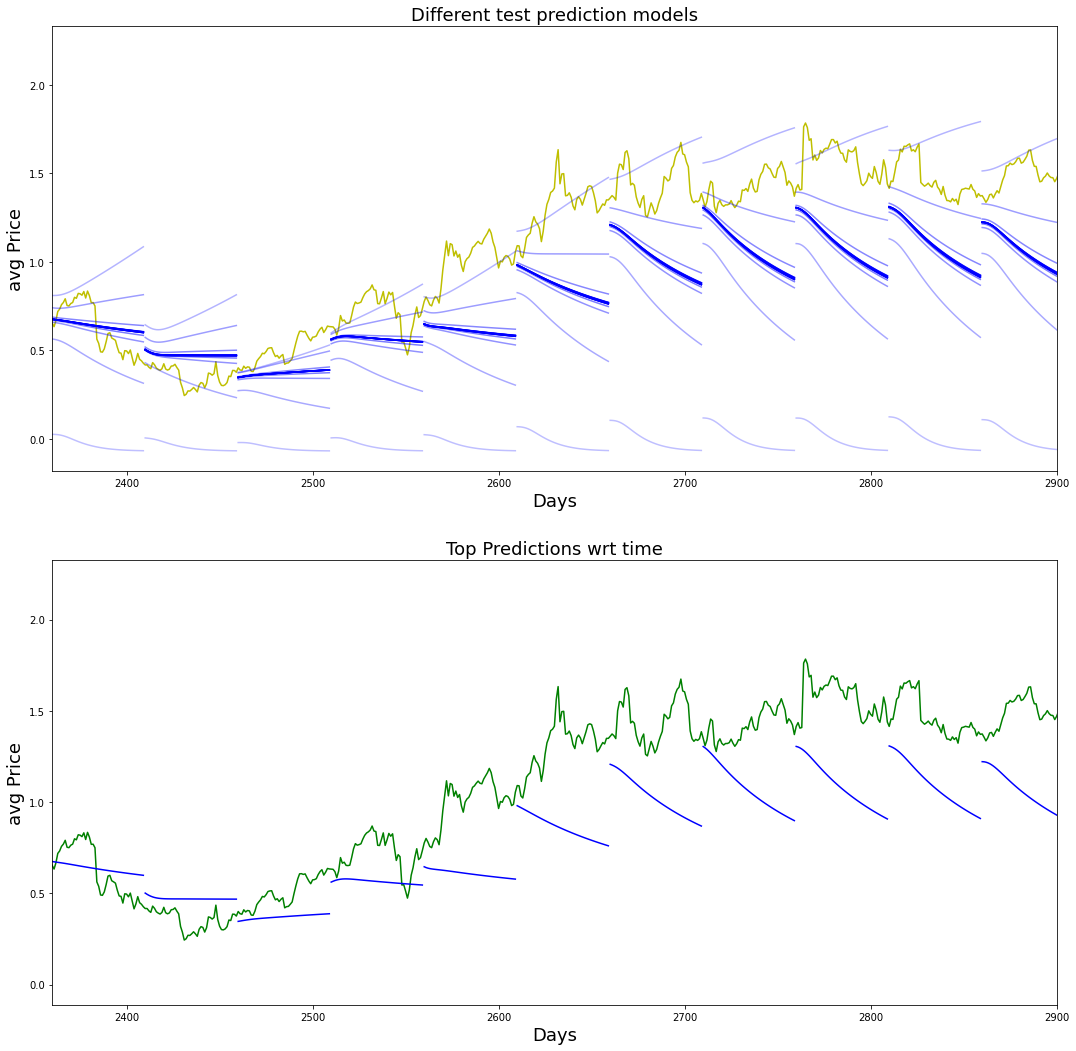

In [ ]:
best_prediction_epoch = 49 # replace this with the epoch that you got the best results when running the plotting code

plt.figure(figsize = (18,18))
plt.subplot(2,1,1)
plt.plot(range(data.shape[0]),avg_data,color='y',label='data')


start_alpha = 0.25
alpha  = np.arange(start_alpha,1.1,(1.0-start_alpha)/len(predictions_over_time[::3]))
for p_i,p in enumerate(predictions_over_time[::3]):
    for xval,yval in zip(x_axis_seq,p):
        plt.plot(xval,yval,color='b',alpha=alpha[p_i],label='stock price movement change')

plt.title('Different test prediction models',fontsize=18)
plt.xlabel('Days',fontsize=18)
plt.ylabel('avg Price',fontsize=18)
plt.xlim(2360,2900)

plt.subplot(2,1,2)

# Predicting the best test prediction you got
plt.plot(range(data.shape[0]),avg_data,color='g',label='predictions')
for xval,yval in zip(x_axis_seq,predictions_over_time[best_prediction_epoch]):
    plt.plot(xval,yval,color='b',label='change in price movement')
    
plt.title('Top Predictions wrt time',fontsize=18)
plt.xlabel('Days',fontsize=18)
plt.ylabel('avg Price',fontsize=18)
plt.xlim(2360,2900)
plt.show()

In [ ]:
class Generator(object):   
    
    def __init__(self,prices,batch_size,num_unroll): #helps to generate data 
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_sequential(self): 
      
        batch_data = np.zeros((self._batch_size),dtype=np.float32)  
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)
        
        for b in range(self._batch_size):   #create batches 
            if self._cursor[b]+1>=self._prices_length:
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)
                
            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(1,5)]
            
            self._cursor[b] = (self._cursor[b]+1)%self._prices_length
            
        return batch_data,batch_labels
    
    def unroll_batch(self):   #roll out the batches generated in form of data and labels 
            
        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):
            
            data, labels = self.next_sequential()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels
    
    def reset_indices(self): #get prices length 
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))
        


dg = Generator(train_avg,5,5)
u_data, u_labels = dg.unroll_batch()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [0.         0.08007819 0.8327337  0.6320342  0.85048705]

	Output: [0.04877708 0.09787335 0.845472   0.64397806 0.83088475]


Unrolled index 1
	Inputs:  [0.04877708 0.08360931 0.845472   0.6453313  0.8628652 ]

	Output: [0.04566491 0.08195347 0.8088188  0.6156187  0.81801945]


Unrolled index 2
	Inputs:  [0.05184934 0.08195347 0.8494527  0.64133036 0.85154223]

	Output: [0.04803894 0.08067668 0.8210365  0.64397806 0.83088475]


Unrolled index 3
	Inputs:  [0.04482704 0.09220763 0.8183113  0.64397806 0.8626623 ]

	Output: [0.04566491 0.09787335 0.8088188  0.60961735 0.83088475]


Unrolled index 4
	Inputs:  [0.04566491 0.09787335 0.8088188  0.60961735 0.83088475]

	Output: [0.04438814 0.07299605 0.84377253 0.71016955 0.7943588 ]


In [ ]:
D = 1 
no_unrolling = 75
batch_size = 300
nodes = [250,250,175] 
num_layers = len(nodes) 
dropout = 0.2

tf.reset_default_graph()

In [ ]:
train_inputs, train_outputs = [],[]

# You unroll the input over time defining placeholders for each time step
for ui in range(no_unrolling):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))

In [ ]:
lstm_cells = [
    tf.contrib.rnn.LSTMCell(num_units=nodes[li],
                            state_is_tuple=True,
                            initializer= tf.contrib.layers.xavier_initializer()
                           )
 for li in range(num_layers)]

drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
    lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]
drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

w = tf.get_variable('w',shape=[nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))

In [ ]:
feat, labs = [],[]
initial_state = []
for li in range(num_layers):
  feat.append(tf.Variable(tf.zeros([batch_size, nodes[li]]), trainable=False))
  labs.append(tf.Variable(tf.zeros([batch_size, nodes[li]]), trainable=False))
  initial_state.append(tf.contrib.rnn.LSTMStateTuple(feat[li], labs[li]))
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)
all_lstm_outputs, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*no_unrolling,nodes[-1]])

all_outputs = tf.nn.xw_plus_b(all_lstm_outputs,w,b)

split_outputs = tf.split(all_outputs,no_unrolling,axis=0)

In [ ]:
print('Loss for the input train while converting prices into movements')
loss = 0.0
with tf.control_dependencies([tf.assign(feat[li], state[li][0]) for li in range(num_layers)]+
                             [tf.assign(labs[li], state[li][1]) for li in range(num_layers)]):
  for ui in range(no_unrolling):
    loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.assign(global_step,global_step + 1)
tf_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(
    tf.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

# Optimizer.
print('TF Optimization operations')
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ =  tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(
    zip(gradients, v))

Loss for the input train while converting prices into movements
Learning rate decay operations
TF Optimization operations


In [ ]:
print('Defining prediction related TF functions')

sample_inputs = tf.placeholder(tf.float32, shape=[1,D])

# Maintaining LSTM state for prediction stage
sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(num_layers):
  sample_c.append(tf.Variable(tf.zeros([1, nodes[li]]), trainable=False))
  sample_h.append(tf.Variable(tf.zeros([1, nodes[li]]), trainable=False))
  initial_sample_state.append(tf.contrib.rnn.LSTMStateTuple(sample_c[li],sample_h[li]))

reset_sample_states = tf.group(*[tf.assign(sample_c[li],tf.zeros([1, nodes[li]])) for li in range(num_layers)],
                               *[tf.assign(sample_h[li],tf.zeros([1, nodes[li]])) for li in range(num_layers)])

sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(num_layers)]+
                              [tf.assign(sample_h[li],sample_state[li][1]) for li in range(num_layers)]):  
  sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)


Defining prediction related TF functions


In [ ]:
epochs = 5
val_sum = 1 

predict_once = 50 # Number of steps you continously predict for

train_seq_length = train_avg.size # Full length of the training data

train_mse_ot = [] # Accumulate Train losses
test_mse_ot = [] # Accumulate Test loss
predictions_over_time = [] # Accumulate predictions

session = tf.InteractiveSession()

tf.global_variables_initializer().run()

# Used for decaying learning rate
loss_nondecrease_count = 0
loss_nondecrease_threshold = 2 # If the test error hasn't increased in this many steps, decrease learning rate

print('Initialized')
average_loss = 0

# Define data generator
data_gen = Generator(train_avg,batch_size,no_unrolling) 

x_axis_seq = []

# Points you start our test predictions from
test_points_seq = np.arange(2360,2900,50).tolist() 

for ep in range(epochs):       
    
    #Training
    for step in range(train_seq_length//batch_size):
        
        u_data, u_labels = data_gen.unroll()

        feed_dict = {}
        for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)
        
        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})

        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l
    
    #Validation
    if (ep+1) % val_sum == 0:

      average_loss = average_loss/(val_sum*(train_seq_length//batch_size))
      
      # The average loss
      if (ep+1)%val_sum==0:
        print('Average loss at step %d: %f' % (ep+1, average_loss))
      
      train_mse_ot.append(average_loss)
            
      average_loss = 0 # reset loss
      
      predictions_seq = []
      
      mse_test_error_seq = []
      

      for w_i in test_points_seq:
        mse_test_error = 0.0
        our_predictions = []
        
        if (ep+1)-val_sum==0:
   
          x_axis=[]
 
        for tr_i in range(w_i-no_unrolling+1,w_i-1):
          current_price = avg_data[tr_i]
          feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)    
          _ = session.run(sample_prediction,feed_dict=feed_dict)
        
        feed_dict = {}
        
        current_price = avg_data[w_i-1]
        
        feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)
 
        for pred_i in range(predict_once):

          pred = session.run(sample_prediction,feed_dict=feed_dict)
        
          our_predictions.append(np.asscalar(pred))
        
          feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)

          if (ep+1)-val_sum==0:
            # Only calculate x_axis values in the first validation epoch
            x_axis.append(w_i+pred_i)

          mse_test_error += 0.5*(pred-avg_data[w_i+pred_i])**2
        
        session.run(reset_sample_states)
        
        predictions_seq.append(np.array(our_predictions))
        
        mse_test_error /= predict_once
        mse_test_error_seq.append(mse_test_error)
        
        if (ep+1)-val_sum==0:
          x_axis_seq.append(x_axis)
        
      current_test_mse = np.mean(mse_test_error_seq)
      

      if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
          loss_nondecrease_count += 1
      else:
          loss_nondecrease_count = 0
      
      if loss_nondecrease_count > loss_nondecrease_threshold :
            session.run(inc_gstep)
            loss_nondecrease_count = 0
            print('\tDecreasing learning rate by 0.5')
      
      test_mse_ot.append(current_test_mse)
      print('\tTest MSE: %.5f'%np.mean(mse_test_error_seq))
      predictions_over_time.append(predictions_seq)
      print('\tFinished Predictions')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Initialized
Average loss at step 1: 8.389716


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


	Test MSE: 0.45260
	Finished Predictions
Average loss at step 2: 2.223857
	Test MSE: 0.12203
	Finished Predictions
Average loss at step 3: 1.477358
	Test MSE: 0.13241
	Finished Predictions
Average loss at step 4: 1.088055
	Test MSE: 0.05773
	Finished Predictions
Average loss at step 5: 0.785437
	Test MSE: 0.07569
	Finished Predictions


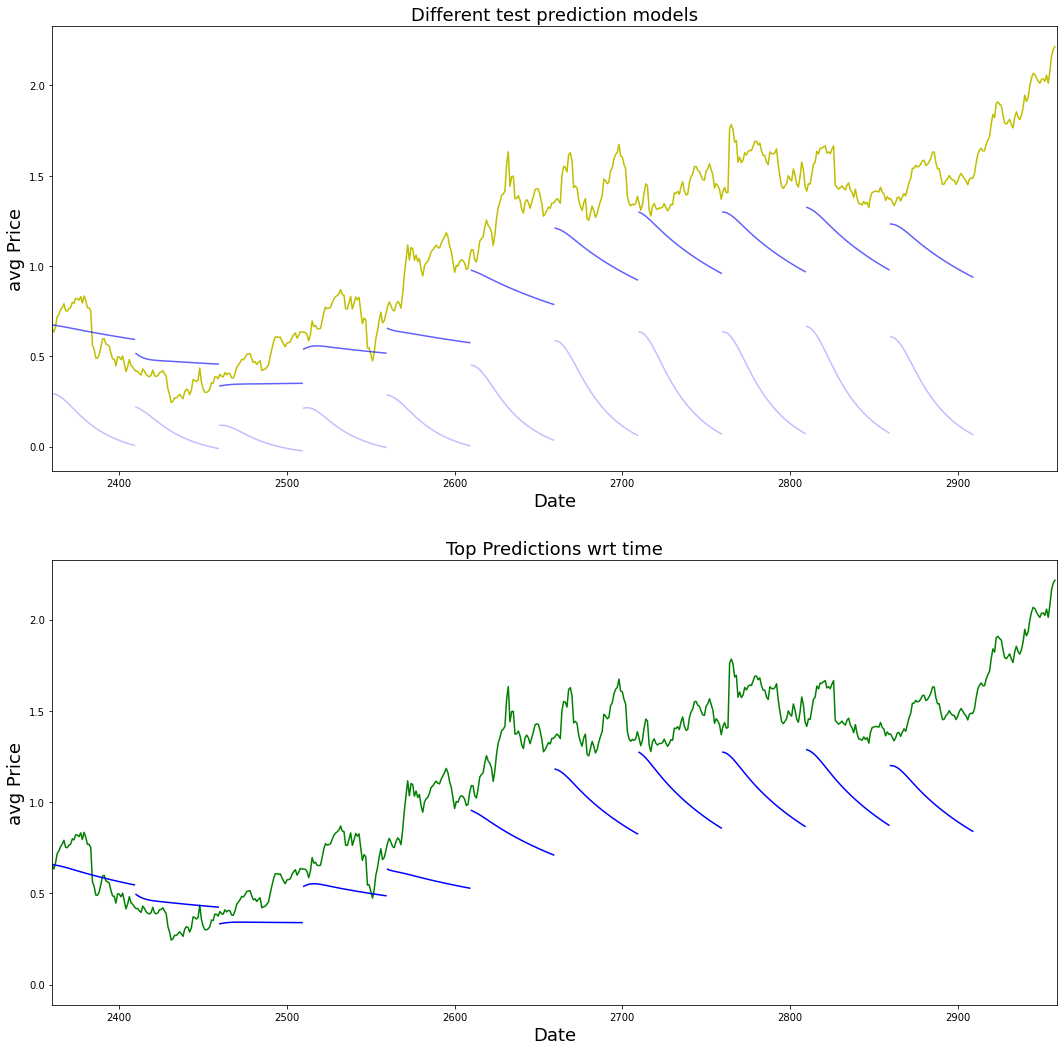

In [ ]:
best_prediction_epoch = 4 # replace this with the epoch that you got the best results when running the plotting code

plt.figure(figsize = (18,18))
plt.subplot(2,1,1)
plt.plot(range(data.shape[0]),avg_data,color='y')

# Plotting how the predictions change over time
# Plot older predictions with low alpha and newer predictions with high alpha
start_alpha = 0.25
alpha  = np.arange(start_alpha,1.1,(1.0-start_alpha)/len(predictions_over_time[::3]))
for p_i,p in enumerate(predictions_over_time[::3]):
    for xval,yval in zip(x_axis_seq,p):
        plt.plot(xval,yval,color='b',alpha=alpha[p_i])

plt.title('Different test prediction models',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('avg Price',fontsize=18)
plt.xlim(2360,2959)

plt.subplot(2,1,2)

# Predicting the best test prediction you got
plt.plot(range(data.shape[0]),avg_data,color='g')
for xval,yval in zip(x_axis_seq,predictions_over_time[best_prediction_epoch]):
    plt.plot(xval,yval,color='b')
    
plt.title('Top Predictions wrt time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('avg Price',fontsize=18)
plt.xlim(2360,2959)
plt.show()
